# cgl1 Fourier Coefficients

Get Fourier coefficients for $\mathcal{H}$-functions. To be used to generate two-parameter bifurcation diagrams in XPP.

Optional: Manually create XPP-compatible tables for the $\mathcal{H}$-functions.

To create XPP-compatible tables, recall from [here](https://sites.pitt.edu/~phase/bard/bardware/xpp/help/xppodes.html): that we require the format:

```
npts
xlo
xhi
y(xlo)
...
y(xhi)
```

The domain of the function is `[xlo,xhi]`

In XPP, the format to load the file is given by,

`table name filename`



# Inits

In [1]:
import sys; sys.path.insert(0, '..') # add parent folder path where lib folder is
# user-defined
import nmCoupling as nm
# import nmCoupling_old as nm
import response as rp

import cgl1 as c1
from lib.functions import g3

from lib.util import (get_phase, freq_est, get_tongue_1d, pl_exist_1d, 
                      get_period, bif1d, follow_phase_diffs, _get_sol,
                      get_phase_diff_f_v2, get_period_all)

from generate_figures import _full_cgl1

from lib.rhs import _redu_c, _full, rhs_avg_1df
from lib.plot_util import (add_diagram_1d_scatter, quick_plot_combined,
                           add_diagram_full, add_diagram_1d,
                           load_diagram_full_f)

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import sympy as sym

from scipy.optimize import root,bisect
from copy import deepcopy
import os

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

nmc = nm.nmCoupling
rsp = rp.Response

## Dicts

In [2]:
def g4(x):
    return (g3(x)/2.7)**3

In [3]:
kw_sim = {'rtol':1e-9,'atol':1e-9,'method':'LSODA'}

In [4]:
pbar3 = 1.266065877752
kws1 = {'var_names':['x','y'],
       'init':np.array([1,0,2*np.pi]),
       'TN':2000,
       'idx':0,
       'model_name':'cglf0',
       'trunc_order':1,
       'recompute_list':[],
       'g_forward':False,
       'z_forward':False,
       'i_forward':[False,True,True,True,True,True,True],
       'i_bad_dx':[False,True,False,False,False,False,False],
       'max_iter':20,
       'rtol':1e-12,
       'atol':1e-12,
       'rel_tol':1e-9,
       'forcing_fn':[lambda x: -g4(x),lambda x:20*(g4(x+2))],
       #'forcing_fn':[lambda x: -g3(x),lambda x:20*g3(x+1)],
       'rhs':c1.rhs_old2}

In [5]:
pd_cgl_template = {'sig':.08,'rho':.12,'mu':1,'om':1,'om_fix':1}

In [6]:
cos = np.cos
sin = np.sin
exp = np.exp

In [7]:
x = np.linspace(-np.pi,np.pi,10000000)
np.mean(g3(x))
# just take from 

1.2660657879333639

## Defs

In [8]:
data_dir = 'xpp_tables/'
if not(os.path.isdir(data_dir)):
    os.mkdir(data_dir)

In [9]:
kw_bif = {'method':'LSODA','dense_output':True,'rtol':1e-10,'atol':1e-10}

In [10]:
eps_list11r = np.linspace(0.001,.1,50)
etup11 = (.001,.1,50)

In [11]:
x_temp = np.linspace(-np.pi,3*np.pi,500)

In [12]:
def get_coeffs(a,k):
    coeffs = np.fft.fft(a.system1.h['dat'][k])
    
    # get coeffs above threshold
    threshold = 0.1
    coeffs_re_all = np.real(coeffs)
    coeffs_im_all = np.imag(coeffs)
    nn = np.arange(len(coeffs),dtype='int')
    
    coeffs_re_bool = (np.abs(coeffs_re_all) > threshold)*(nn<a.NH/2)
    coeffs_im_bool = (np.abs(coeffs_im_all) > threshold)*(nn<a.NH/2)
    
    print(coeffs_re_bool.sum(),np.where(coeffs_re_bool>0))
    print(coeffs_im_bool.sum(),np.where(coeffs_im_bool>0))
    
    print('re',coeffs_re_all[coeffs_re_bool])
    print('im',coeffs_im_all[coeffs_im_bool])
    
    freqs = np.fft.fftfreq(len(coeffs),d=(1/a.NH))
    
    coeffs_re = coeffs_re_all[coeffs_re_bool]
    coeffs_im = coeffs_im_all[coeffs_im_bool]
    
    freqs[coeffs_re_bool]

    return coeffs_re, coeffs_im, freqs[coeffs_re_bool], freqs[coeffs_im_bool]

def call_fourier_series(a,coeffs_re,coeffs_im,fr,fi):
    tot = 0
    for i,c in enumerate(coeffs_re):
        if fr[i] == 0:
            tot += c/a.NH
        else:
            tot += 2*c*np.cos(a.x*fr[i])/a.NH
    
    for i,c in enumerate(coeffs_im):
        tot += -2*c*np.sin(a.x*fi[i])/a.NH

    return tot

def print_fourier_series(a,coeffs_re,coeffs_im,fr,fi):
    # display copy/paste-able equation
    eq = ''
    for i,c in enumerate(coeffs_re):
        if fr[i] == 0:
            eq += '{:.4f}'.format(c/a.NH)
        else:
            eq += '+2*cos(x*{})*({:.4f})'.format(fr[i],c/a.NH)
    
    for i,c in enumerate(coeffs_im):
        eq += '-2*sin(x*{})*({:.4f})'.format(fi[i],c/a.NH)
        #tot += -2*c*np.sin(x*freqs[coeffs_re_bool][i])/a.NH
    return eq


## Initialize Response Functions

In [13]:
system1 = rsp(**{'pardict':pd_cgl_template,**kws1})

mkdir ./data/cglf0/
* Loading LC data...
self.T 6.283185307179586 omfix 1.0000000000003393
* Loading monodromy...
* Floquet Exponent kappa =-0.16000000000685696
* Loading g symbolic...
* Computing g...
* Loading heterogeneous terms...
* Computing z...
* Computing i...


# 1:1

In [14]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm11 = {'system1':system1,'system2':None,'_n':('om0',1),'_m':('om1',1),
         'NH':300,'save_fig':False,'recompute_list':recompute_list}

In [15]:
a11 = nm.nmCoupling(**kw_nm11)

Initializing 11 Coupling...
* Loading p...
p order=0
* Computing H cglf0, order=0...
p order=1
* Computing H cglf0, order=1...


Might need to stick with Fourier coefficients. At least for CGL. Much simpler this way.

Recall: Given the fourier coefficients $c_n$ for $n \in\mathbb{Z}$ and supposing that $c_n = a_n + i b_n$, the real Fourier series is given by,
$$\sum_{n =1}^\infty 2 a_n \cos(n \omega t) - 2 b_n \sin(n \omega t).$$
So I really only need to save the coefficients for positive frequencies and double them. 

Goal: given a function, display a list of coefficients (maybe implement text output to copy/past into XPP)

## eps coeffs

In [16]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a11,0)

1 (array([1]),)
1 (array([1]),)
re [-45.19170366]
im [-30.12780197]


In [17]:
tot = call_fourier_series(a11,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a11,coeffs_re,coeffs_im,fr,fi))

+2*cos(x*1.0)*(-0.1506)-2*sin(x*1.0)*(-0.1004)


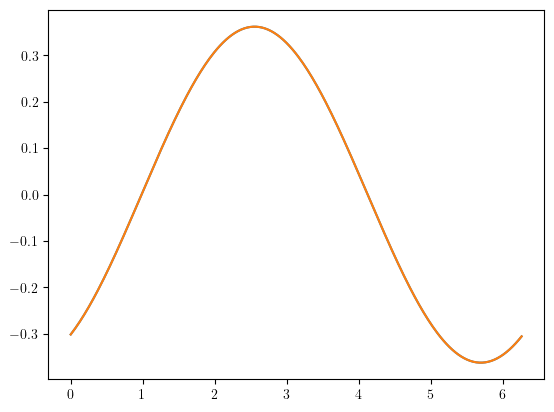

In [18]:
fig,axs = plt.subplots()
axs.plot(a11.x,tot)
axs.plot(a11.x,a11.system1.h['dat'][0])

## eps^2 coeffs

In [19]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a11,1)

2 (array([0, 1]),)
2 (array([1, 2]),)
re [ 34.46083393 171.77496584]
im [-1072.60578673   -64.52646952]


In [20]:
tot = call_fourier_series(a11,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a11,coeffs_re,coeffs_im,fr,fi))

0.1149+2*cos(x*1.0)*(0.5726)-2*sin(x*1.0)*(-3.5754)-2*sin(x*2.0)*(-0.2151)


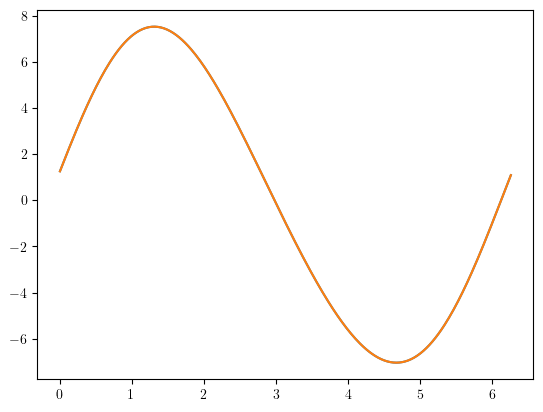

In [21]:
fig,axs = plt.subplots()
axs.plot(a11.x,tot)
axs.plot(a11.x,a11.system1.h['dat'][1])

## eps^3 coeffs

In [22]:
# coeffs_re, coeffs_im, fr, fi = get_coeffs(a11,2)

In [23]:
# tot = call_fourier_series(a11,coeffs_re,coeffs_im,fr,fi)
# print(print_fourier_series(a11,coeffs_re,coeffs_im,fr,fi))

In [24]:
# fig,axs = plt.subplots()
# axs.plot(a11.x,tot)
# axs.plot(a11.x,a11.system1.h['dat'][2])

## Save data

In [25]:
# xlo = a11.x[0]
# xhi = a11.x[-1]
# npts = len(a11.x)
# fname = 'xtab{}{}o{}.dat'

# if not(os.path.isdir(data_dir)):
#     os.mkdir(data_dir)

# for k in range(a11.system1.miter):
#     d = a11.system1.h['dat'][k]
#     d = np.insert(d,0,xhi)
#     d = np.insert(d,0,xlo)
#     d = np.insert(d,0,npts)
#     np.savetxt((data_dir+fname).format(a11._n[1],a11._m[1],k),d,
#               fmt='%.18f')

# 2:1

In [26]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm21 = {'system1':system1,'system2':None,'_n':('om0',2),'_m':('om1',1),
         'NH':300,'save_fig':False,'recompute_list':recompute_list}

In [27]:
a21 = nm.nmCoupling(**kw_nm21)

Initializing 21 Coupling...
* Loading p...
* Loading H cglf0, order=0...
* Loading H cglf0, order=1...


## eps coeffs

In [28]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a21,0)

1 (array([2]),)
1 (array([2]),)
re [-25.66543726]
im [-17.11029124]


In [29]:
tot = call_fourier_series(a21,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a21,coeffs_re,coeffs_im,fr,fi))

+2*cos(x*2.0)*(-0.0856)-2*sin(x*2.0)*(-0.0570)


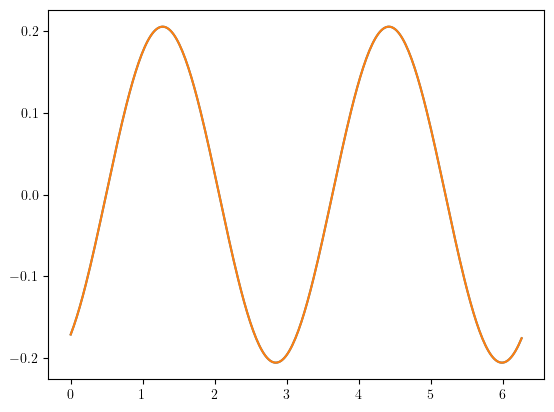

In [30]:
fig,axs = plt.subplots()
axs.plot(a21.x,tot)
axs.plot(a21.x,a21.system1.h['dat'][0])

## eps^2 coeffs

In [31]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a21,1)

2 (array([0, 2]),)
2 (array([2, 4]),)
re [  41.02538873 -594.503209  ]
im [164.79268484 -20.91480863]


In [32]:
tot = call_fourier_series(a21,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a21,coeffs_re,coeffs_im,fr,fi))

0.1368+2*cos(x*2.0)*(-1.9817)-2*sin(x*2.0)*(0.5493)-2*sin(x*4.0)*(-0.0697)


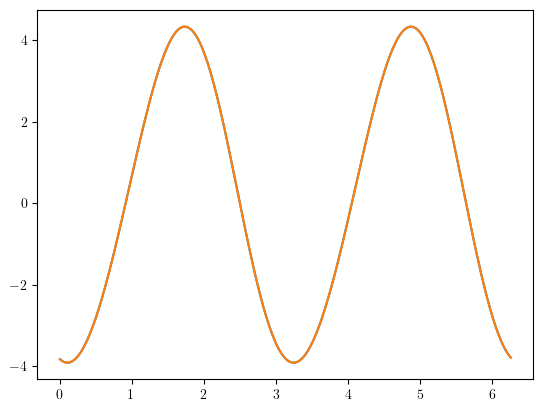

In [33]:
fig,axs = plt.subplots()
axs.plot(a21.x,tot)
axs.plot(a21.x,a21.system1.h['dat'][1])

## eps^3 coeffs

In [36]:
# coeffs_re, coeffs_im, fr, fi = get_coeffs(a21,2)

In [37]:
# tot = call_fourier_series(a21,coeffs_re,coeffs_im,fr,fi)
# print(print_fourier_series(a21,coeffs_re,coeffs_im,fr,fi))

In [38]:
# fig,axs = plt.subplots()
# axs.plot(a21.x,tot)
# axs.plot(a21.x,a21.system1.h['dat'][2])

## Save data

In [39]:
# xlo = a21.x[0]
# xhi = a21.x[-1]
# npts = len(a21.x)
# fname = 'xtab{}{}o{}.dat'

# if not(os.path.isdir(data_dir)):
#     os.mkdir(data_dir)

# for k in range(a21.system1.miter):
#     d = a21.system1.h['dat'][k]
#     d = np.insert(d,0,xhi)
#     d = np.insert(d,0,xlo)
#     d = np.insert(d,0,npts)
#     np.savetxt((data_dir+fname).format(a21._n[1],a21._m[1],k),d,
#               fmt='%.18f')

## Quick diagrams

(0.0, 0.2)

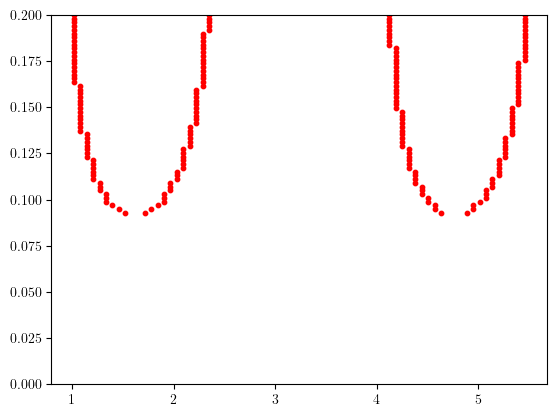

In [40]:
eps_list = np.linspace(0,.2,100)
# find fixed points
x = np.linspace(0,2*np.pi,100)
d = 0.05

fig,axs = plt.subplots()

for eps in eps_list:
    y1 = eps*a21.system1.h['lam'][0](x)-d
    y2 = eps*a21.system1.h['lam'][0](x) + eps**2*a21.system1.h['lam'][1](x)-d
    pts1 = x[1:][(y1[1:]>0)*(y1[:-1]<=0) + (y1[1:]<0)*(y1[:-1]>=0)]
    pts2 = x[1:][(y2[1:]>0)*(y2[:-1]<=0) + (y2[1:]<0)*(y2[:-1]>=0)]
    axs.scatter(pts1,eps*np.ones(len(pts1)),color='orange',s=10)
    axs.scatter(pts2,eps*np.ones(len(pts2)),color='red',s=10)

axs.set_ylim(0,eps_list[-1])

# 3:1

In [41]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm31 = {'system1':system1,'system2':None,'_n':('om0',3),'_m':('om1',1),
         'NH':300,'save_fig':False,'recompute_list':recompute_list}

In [42]:
a31 = nm.nmCoupling(**kw_nm31)

Initializing 31 Coupling...
* Loading p...
* Loading H cglf0, order=0...
* Loading H cglf0, order=1...


## eps coeffs

In [43]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a31,0)

1 (array([3]),)
1 (array([3]),)
re [-10.97112065]
im [-7.31408032]


In [44]:
tot = call_fourier_series(a31,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a31,coeffs_re,coeffs_im,fr,fi))

+2*cos(x*3.0)*(-0.0366)-2*sin(x*3.0)*(-0.0244)


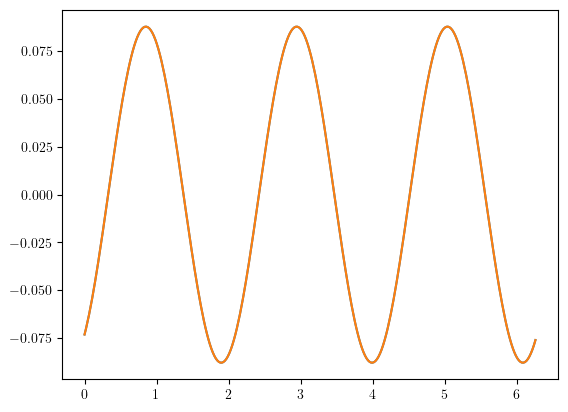

In [45]:
fig,axs = plt.subplots()
axs.plot(a31.x,tot)
axs.plot(a31.x,a31.system1.h['dat'][0])

## eps^2 coeffs

In [46]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a31,1)

2 (array([0, 3]),)
2 (array([3, 6]),)
re [ 31.94511945 169.8095332 ]
im [201.7652747   -3.83987623]


In [47]:
tot = call_fourier_series(a31,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a31,coeffs_re,coeffs_im,fr,fi))

0.1065+2*cos(x*3.0)*(0.5660)-2*sin(x*3.0)*(0.6726)-2*sin(x*6.0)*(-0.0128)


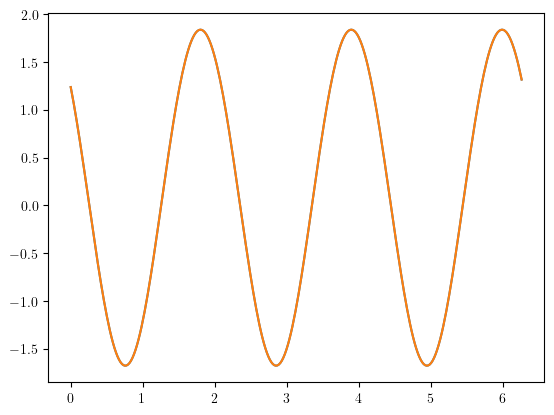

In [48]:
fig,axs = plt.subplots()
axs.plot(a31.x,tot)
axs.plot(a31.x,a31.system1.h['dat'][1])

## eps^3 coeffs

In [49]:
# coeffs_re, coeffs_im, fr, fi = get_coeffs(a31,2)

In [50]:
# tot = call_fourier_series(a31,coeffs_re,coeffs_im,fr,fi)
# print(print_fourier_series(a31,coeffs_re,coeffs_im,fr,fi))

In [51]:
# fig,axs = plt.subplots()
# axs.plot(a31.x,tot)
# axs.plot(a31.x,a31.system1.h['dat'][2])

## Save data

In [52]:
# xlo = a31.x[0]
# xhi = a31.x[-1]
# npts = len(a31.x)
# fname = 'xtab{}{}o{}.dat'

# if not(os.path.isdir(data_dir)):
#     os.mkdir(data_dir)

# for k in range(a31.system1.miter):
#     d = a31.system1.h['dat'][k]
#     d = np.insert(d,0,xhi)
#     d = np.insert(d,0,xlo)
#     d = np.insert(d,0,npts)
#     np.savetxt((data_dir+fname).format(a31._n[1],a31._m[1],k),d,
#               fmt='%.18f')

# 4:1

In [53]:
#recompute_list = ['h_data_cglf0','h_data_cglf0','p_data_cglf0','p_data_cglf0']
recompute_list = []
kw_nm41 = {'system1':system1,'system2':None,'_n':('om0',4),'_m':('om1',1),
         'NH':300,'save_fig':False,'recompute_list':recompute_list}

In [54]:
a41 = nm.nmCoupling(**kw_nm41)

Initializing 41 Coupling...
* Loading p...
p order=0
* Computing H cglf0, order=0...
p order=1
* Computing H cglf0, order=1...


## eps coeffs

In [55]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a41,0)

1 (array([4]),)
1 (array([4]),)
re [-3.72319597]
im [-2.48213061]


In [56]:
tot = call_fourier_series(a41,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a41,coeffs_re,coeffs_im,fr,fi))

+2*cos(x*4.0)*(-0.0124)-2*sin(x*4.0)*(-0.0083)


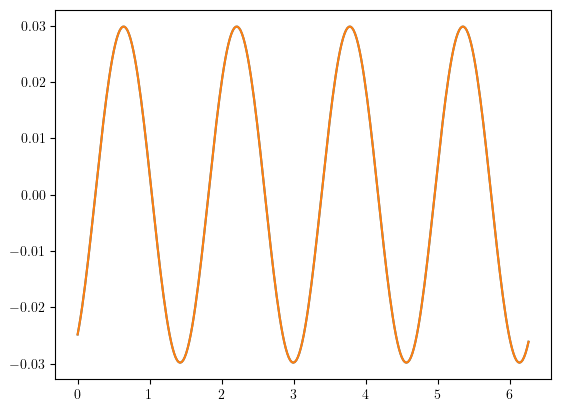

In [57]:
fig,axs = plt.subplots()
axs.plot(a41.x,tot)
axs.plot(a41.x,a41.system1.h['dat'][0])

## eps^2 coeffs

In [58]:
coeffs_re, coeffs_im, fr, fi = get_coeffs(a41,1)

2 (array([0, 4]),)
2 (array([4, 8]),)
re [23.22005581 38.27982494]
im [-80.89449449  -0.44410333]


In [59]:
tot = call_fourier_series(a41,coeffs_re,coeffs_im,fr,fi)
print(print_fourier_series(a41,coeffs_re,coeffs_im,fr,fi))

0.0774+2*cos(x*4.0)*(0.1276)-2*sin(x*4.0)*(-0.2696)-2*sin(x*8.0)*(-0.0015)


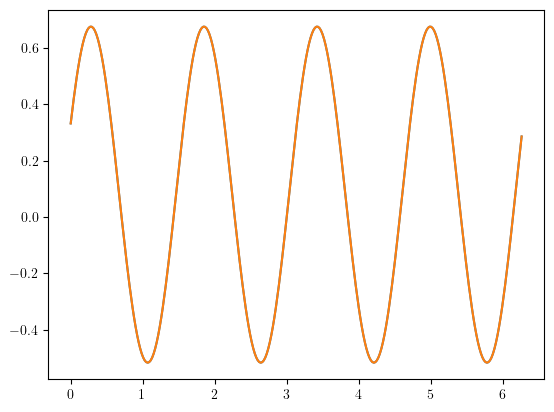

In [60]:
fig,axs = plt.subplots()
axs.plot(a41.x,tot)
axs.plot(a41.x,a41.system1.h['dat'][1])

## eps^3 coeffs

In [61]:
# coeffs_re, coeffs_im, fr, fi = get_coeffs(a41,2)

In [62]:
# tot = call_fourier_series(a41,coeffs_re,coeffs_im,fr,fi)
# print(print_fourier_series(a41,coeffs_re,coeffs_im,fr,fi))

In [63]:
# fig,axs = plt.subplots()
# axs.plot(a41.x,tot)
# axs.plot(a41.x,a41.system1.h['dat'][2])

## Save data

In [64]:
# xlo = a41.x[0]
# xhi = a41.x[-1]
# npts = len(a41.x)
# fname = 'xtab{}{}o{}.dat'

# if not(os.path.isdir(data_dir)):
#     os.mkdir(data_dir)

# for k in range(a41.system1.miter):
#     d = a41.system1.h['dat'][k]
#     d = np.insert(d,0,xhi)
#     d = np.insert(d,0,xlo)
#     d = np.insert(d,0,npts)
#     np.savetxt((data_dir+fname).format(a41._n[1],a41._m[1],k),d,
#               fmt='%.18f')